In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Just to push


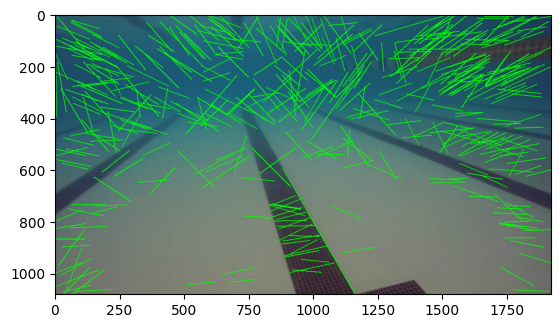

In [101]:
img = cv2.imread('rov_pool.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 0, 100, apertureSize=7) # detect edges, gray is image in grayscale, 50 and 150 represent 2 images that have been threshholded at 2 different levels, apertureSize controls how much light the image gets and how exposed it is
lines = cv2.HoughLinesP(
                edges, #described above
                1, #1 pixel resolution parameter
                np.pi/180, # 1 degree resolution parameter
                10, #min number of intersections/votes
                minLineLength=100,
                maxLineGap=7,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

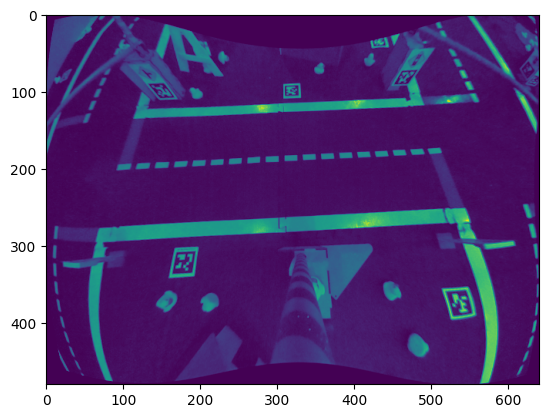

In [3]:
from dt_apriltags import Detector
img = cv2.imread('test_image.png', cv2.IMREAD_GRAYSCALE)

at_detector = Detector(families='tag36h11', #controls what it is supposed to detect
                       nthreads=1, #controls the number of threads used in the detection
                       quad_decimate=1.0, #controls to what scale the image is lowered in resolution
                       quad_sigma=0.0, #blur applied to the image to reduce noise
                       refine_edges=1, #attempts to redefine the edges of the tag boundaries
                       decode_sharpening=0.25, #controls how much the image is sharpened after the tags are discovered
                       debug=0) # no debugging information will be produced

tags = at_detector.detect(img, estimate_tag_pose=False, camera_params=None, tag_size=None)

color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for tag in tags:
    for idx in range(len(tag.corners)):
        cv2.line(color_img, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))

    cv2.putText(color_img, str(tag.tag_id),
                org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.8,
                color=(0, 0, 255))
    
plt.imshow(img)